# Bagnet Training
This notebook trains a bagnet17 model on the plant dataset

In [1]:
import time
import os

import bagnets.pytorchnet
import numpy as np
import pandas as pd
from plotnine import *
import sklearn.model_selection
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import torch.backends.cudnn as cudnn
import tqdm

In [2]:
seed = 42

np.random.seed(seed)                                                                       
torch.manual_seed(seed)                                                                    
if torch.backends.cudnn.enabled:                                                                
    torch.backends.cudnn.deterministic = True                                                   
    torch.backends.cudnn.benchmark = False

In [3]:
data_dir = '../data/'

data_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
])

image_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform = data_transform)

train_indices, tune_indices = sklearn.model_selection.train_test_split(np.arange(len(image_dataset)), 
                                                                       test_size=.1, random_state=seed)

train_data = torch.utils.data.Subset(image_dataset, train_indices)
tune_data = torch.utils.data.Subset(image_dataset, tune_indices)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
tune_dataloader = torch.utils.data.DataLoader(tune_data)

dataset_size = len(image_dataset)
class_names = image_dataset.classes

device = torch.device("cuda")

model = bagnets.pytorchnet.bagnet17(num_classes = 12)

criterion = nn.CrossEntropyLoss()
criterion = criterion.cpu()
optimizer = optim.Adam(model.parameters(), lr=0.01)

model.to(device)
overall_step = 0
epochs = 250

best_tune_loss = None
tune_losses = []
train_losses = []
tune_accuracies = []

for epoch in tqdm.tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
    train_loss = 0
    tune_loss = 0
    tune_correct = 0
    for data in tqdm.tqdm_notebook(train_dataloader, total=len(train_dataloader)):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    
    for data in tune_dataloader:
        with torch.no_grad():
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            predicted = torch.argmax(outputs.data, 1)
            
            tune_loss += criterion(outputs, labels).item()
            tune_correct += accuracy_score(predicted.cpu(), labels.cpu(), normalize=False)
    
    tune_losses.append(tune_loss)
    train_losses.append(train_loss)

    accuracy = tune_correct / len(tune_data)
    tune_accuracies.append(accuracy)
    
    print('Epoch:\t{}\tTrain Loss:\t{}\tTune Loss:\t{}\tTune Acc:\t{}'.format(epoch, train_loss, 
                                                                              tune_loss, accuracy))
            
    # Save model
    if best_tune_loss is None or tune_loss < best_tune_loss:
        best_tune_loss = tune_loss
        torch.save(model.state_dict(), '../results/trained_bagnet.pkl')


Epoch:	0	Train Loss:	616.0753109455109	Tune Loss:	1260.4228427410126	Tune Acc:	0.13473684210526315



Epoch:	1	Train Loss:	410.2974603176117	Tune Loss:	1374.4801267385483	Tune Acc:	0.13473684210526315



Epoch:	2	Train Loss:	377.10275223851204	Tune Loss:	1236.7101714611053	Tune Acc:	0.10105263157894737



Epoch:	3	Train Loss:	335.4502054452896	Tune Loss:	1480.8829882144928	Tune Acc:	0.12



Epoch:	4	Train Loss:	300.64045467972755	Tune Loss:	1143.6426405906677	Tune Acc:	0.16631578947368422



Epoch:	5	Train Loss:	275.293809145689	Tune Loss:	1433.0241346359253	Tune Acc:	0.21263157894736842



Epoch:	6	Train Loss:	240.51743653416634	Tune Loss:	1208.7500448226929	Tune Acc:	0.1957894736842105



Epoch:	7	Train Loss:	220.64986297488213	Tune Loss:	1243.247947871685	Tune Acc:	0.26526315789473687



Epoch:	8	Train Loss:	224.8546832203865	Tune Loss:	1321.9859037995338	Tune Acc:	0.17894736842105263



Epoch:	9	Train Loss:	200.5315080434084	Tune Loss:	1625.3744540214539	Tune Acc:	0.18526315789473685



Epoch:	10	Train Loss:	188.19913536310196	Tune Loss:	1259.7227167487144	Tune Acc:	0.25894736842105265



Epoch:	11	Train Loss:	177.12108947336674	Tune Loss:	1430.1817498803139	Tune Acc:	0.1431578947368421



Epoch:	12	Train Loss:	179.13792446255684	Tune Loss:	1346.9716448783875	Tune Acc:	0.2



Epoch:	13	Train Loss:	176.84025843441486	Tune Loss:	1342.3901166319847	Tune Acc:	0.24210526315789474



Epoch:	14	Train Loss:	166.6002874672413	Tune Loss:	1532.274509191513	Tune Acc:	0.29894736842105263



Epoch:	15	Train Loss:	158.06080761551857	Tune Loss:	1461.8972462415695	Tune Acc:	0.15368421052631578



Epoch:	16	Train Loss:	161.8606472313404	Tune Loss:	1426.939039170742	Tune Acc:	0.23157894736842105



Epoch:	17	Train Loss:	145.11999797821045	Tune Loss:	1353.4095008969307	Tune Acc:	0.23157894736842105



Epoch:	18	Train Loss:	147.83101949095726	Tune Loss:	1385.585545539856	Tune Acc:	0.21052631578947367



Epoch:	19	Train Loss:	148.2016187608242	Tune Loss:	1204.390462756157	Tune Acc:	0.33473684210526317



Epoch:	20	Train Loss:	130.31426287442446	Tune Loss:	1272.2075744867325	Tune Acc:	0.3263157894736842



Epoch:	21	Train Loss:	132.72905971109867	Tune Loss:	1465.6849168539047	Tune Acc:	0.22526315789473683



Epoch:	22	Train Loss:	122.69751401245594	Tune Loss:	1540.7296065092087	Tune Acc:	0.23789473684210527



Epoch:	23	Train Loss:	126.04297694563866	Tune Loss:	1334.6723854541779	Tune Acc:	0.25894736842105265



Epoch:	24	Train Loss:	116.11431221663952	Tune Loss:	1240.3668440878391	Tune Acc:	0.33473684210526317



Epoch:	25	Train Loss:	114.89661731570959	Tune Loss:	1265.942015916109	Tune Acc:	0.27157894736842103



Epoch:	26	Train Loss:	120.53087604045868	Tune Loss:	1423.1466157734394	Tune Acc:	0.17473684210526316



Epoch:	27	Train Loss:	110.29429081827402	Tune Loss:	1251.0165466666222	Tune Acc:	0.33052631578947367



Epoch:	28	Train Loss:	101.16272635757923	Tune Loss:	1387.1097456812859	Tune Acc:	0.27578947368421053



Epoch:	29	Train Loss:	95.27271389495581	Tune Loss:	1351.3852643966675	Tune Acc:	0.3936842105263158



Epoch:	30	Train Loss:	93.08255548775196	Tune Loss:	1396.086063593626	Tune Acc:	0.23578947368421052



Epoch:	31	Train Loss:	96.33035206794739	Tune Loss:	1533.1340742707253	Tune Acc:	0.19789473684210526



Epoch:	32	Train Loss:	89.3508280441165	Tune Loss:	1378.5076843500137	Tune Acc:	0.3684210526315789



Epoch:	33	Train Loss:	88.80001017451286	Tune Loss:	1204.0782342106104	Tune Acc:	0.3263157894736842



Epoch:	34	Train Loss:	78.98340858146548	Tune Loss:	1253.229863166809	Tune Acc:	0.37894736842105264



Epoch:	35	Train Loss:	86.26888754218817	Tune Loss:	1156.4251952171326	Tune Acc:	0.3684210526315789



Epoch:	36	Train Loss:	78.15455707907677	Tune Loss:	1228.3784534484148	Tune Acc:	0.4336842105263158



Epoch:	37	Train Loss:	74.86257438547909	Tune Loss:	1153.7424558252096	Tune Acc:	0.4168421052631579



Epoch:	38	Train Loss:	67.72529719024897	Tune Loss:	1347.0145862698555	Tune Acc:	0.35578947368421054



Epoch:	39	Train Loss:	71.39402593672276	Tune Loss:	1395.6046830415726	Tune Acc:	0.36210526315789476



Epoch:	40	Train Loss:	76.52100066840649	Tune Loss:	1247.8497035354376	Tune Acc:	0.4063157894736842



Epoch:	41	Train Loss:	61.90768237039447	Tune Loss:	1339.4757222011685	Tune Acc:	0.31157894736842107



Epoch:	42	Train Loss:	65.35952687636018	Tune Loss:	1075.7469331473112	Tune Acc:	0.42736842105263156



Epoch:	43	Train Loss:	68.30807148292661	Tune Loss:	1297.345056682825	Tune Acc:	0.4



Epoch:	44	Train Loss:	68.48092933557928	Tune Loss:	1158.4651301503181	Tune Acc:	0.3263157894736842



Epoch:	45	Train Loss:	61.3333739656955	Tune Loss:	1312.1011642739177	Tune Acc:	0.4189473684210526



Epoch:	46	Train Loss:	54.52993644028902	Tune Loss:	1552.5675349533558	Tune Acc:	0.2968421052631579



Epoch:	47	Train Loss:	54.61655588820577	Tune Loss:	1247.7296891510487	Tune Acc:	0.39789473684210525



Epoch:	48	Train Loss:	57.6492703538388	Tune Loss:	1350.3804557844996	Tune Acc:	0.35789473684210527



Epoch:	49	Train Loss:	47.4573389980942	Tune Loss:	1177.8618163466454	Tune Acc:	0.4421052631578947



Epoch:	50	Train Loss:	46.79239885509014	Tune Loss:	1297.9499339014292	Tune Acc:	0.42105263157894735



Epoch:	51	Train Loss:	46.53399033471942	Tune Loss:	1230.9451554119587	Tune Acc:	0.38526315789473686



Epoch:	52	Train Loss:	51.67510370723903	Tune Loss:	1185.1512822955847	Tune Acc:	0.42736842105263156



Epoch:	53	Train Loss:	44.28784162923694	Tune Loss:	1753.4999174624681	Tune Acc:	0.3663157894736842



Epoch:	54	Train Loss:	46.455706644803286	Tune Loss:	1223.9664650857449	Tune Acc:	0.4126315789473684



Epoch:	55	Train Loss:	32.31343796593137	Tune Loss:	1006.1912396624684	Tune Acc:	0.4673684210526316



Epoch:	56	Train Loss:	37.59405768569559	Tune Loss:	965.7539160400629	Tune Acc:	0.4863157894736842



Epoch:	57	Train Loss:	41.55091659165919	Tune Loss:	1249.7864133864641	Tune Acc:	0.4463157894736842



Epoch:	58	Train Loss:	39.65993742737919	Tune Loss:	1500.3996233195066	Tune Acc:	0.26105263157894737



Epoch:	59	Train Loss:	42.77714323066175	Tune Loss:	1189.3600824028254	Tune Acc:	0.45052631578947366



Epoch:	60	Train Loss:	31.85429580323398	Tune Loss:	1152.5118224024773	Tune Acc:	0.3452631578947368



Epoch:	61	Train Loss:	33.57764811255038	Tune Loss:	1133.4510889723897	Tune Acc:	0.5494736842105263



Epoch:	62	Train Loss:	26.988969165831804	Tune Loss:	1078.2684845626354	Tune Acc:	0.48210526315789476



Epoch:	63	Train Loss:	25.225347716361284	Tune Loss:	1376.824108183384	Tune Acc:	0.28421052631578947



Epoch:	64	Train Loss:	25.67409846803639	Tune Loss:	1152.7565467879176	Tune Acc:	0.45263157894736844



Epoch:	65	Train Loss:	26.631805941462517	Tune Loss:	1086.69031207636	Tune Acc:	0.5178947368421053



Epoch:	66	Train Loss:	30.015294357202947	Tune Loss:	1235.1931141242385	Tune Acc:	0.37684210526315787



Epoch:	67	Train Loss:	36.18384577520192	Tune Loss:	921.759558647871	Tune Acc:	0.4673684210526316



Epoch:	68	Train Loss:	38.258815145120025	Tune Loss:	1145.1046117432415	Tune Acc:	0.47789473684210526



Epoch:	69	Train Loss:	24.38182566408068	Tune Loss:	1170.8809951469302	Tune Acc:	0.4105263157894737



Epoch:	70	Train Loss:	18.47273017792031	Tune Loss:	1112.13611510396	Tune Acc:	0.5389473684210526



Epoch:	71	Train Loss:	27.608717795927078	Tune Loss:	1109.967224046588	Tune Acc:	0.5031578947368421



Epoch:	72	Train Loss:	33.618812097236514	Tune Loss:	876.6073868945241	Tune Acc:	0.4631578947368421



Epoch:	73	Train Loss:	21.50082326028496	Tune Loss:	1099.4212606996298	Tune Acc:	0.42105263157894735



Epoch:	74	Train Loss:	20.591920071281493	Tune Loss:	1177.7014319058508	Tune Acc:	0.4694736842105263



Epoch:	75	Train Loss:	17.282760271802545	Tune Loss:	1233.5067590735853	Tune Acc:	0.39789473684210525



Epoch:	76	Train Loss:	11.62602728838101	Tune Loss:	1281.85858351551	Tune Acc:	0.4968421052631579



Epoch:	77	Train Loss:	28.196635051630437	Tune Loss:	1176.0629108697176	Tune Acc:	0.4589473684210526



Epoch:	78	Train Loss:	18.596539068152197	Tune Loss:	1131.7405285676941	Tune Acc:	0.45473684210526316



Epoch:	79	Train Loss:	17.398112592753023	Tune Loss:	1547.845602767542	Tune Acc:	0.40421052631578946



Epoch:	80	Train Loss:	20.95338178705424	Tune Loss:	1496.29481828399	Tune Acc:	0.4421052631578947



Epoch:	81	Train Loss:	19.084047080017626	Tune Loss:	1140.364709019661	Tune Acc:	0.4589473684210526



Epoch:	82	Train Loss:	15.359661215450615	Tune Loss:	1449.3139689341187	Tune Acc:	0.4673684210526316



Epoch:	83	Train Loss:	16.09681271435693	Tune Loss:	1072.1071680383757	Tune Acc:	0.5073684210526316



Epoch:	84	Train Loss:	15.640009232796729	Tune Loss:	1183.438243471086	Tune Acc:	0.43157894736842106



Epoch:	85	Train Loss:	18.97294964361936	Tune Loss:	1179.5802934803069	Tune Acc:	0.42526315789473684



Epoch:	86	Train Loss:	43.767550812568516	Tune Loss:	1140.1707646250725	Tune Acc:	0.5178947368421053



Epoch:	87	Train Loss:	8.838951251003891	Tune Loss:	1205.795713255182	Tune Acc:	0.47368421052631576



Epoch:	88	Train Loss:	10.422551397699863	Tune Loss:	1062.6489627957344	Tune Acc:	0.4842105263157895



Epoch:	89	Train Loss:	12.794572081707884	Tune Loss:	1076.3206382393837	Tune Acc:	0.5326315789473685



Epoch:	90	Train Loss:	10.987083390820771	Tune Loss:	1184.0011156033725	Tune Acc:	0.5178947368421053



Epoch:	91	Train Loss:	13.956157188396901	Tune Loss:	994.4406085163355	Tune Acc:	0.5368421052631579



Epoch:	92	Train Loss:	14.786326848436147	Tune Loss:	1291.3759705387056	Tune Acc:	0.4610526315789474



Epoch:	93	Train Loss:	24.562806580215693	Tune Loss:	907.9686585664749	Tune Acc:	0.5768421052631579



Epoch:	94	Train Loss:	16.078224868979305	Tune Loss:	917.2097479524091	Tune Acc:	0.5831578947368421



Epoch:	95	Train Loss:	9.393716948572546	Tune Loss:	988.5527184046805	Tune Acc:	0.5515789473684211



Epoch:	96	Train Loss:	14.205162489786744	Tune Loss:	1447.077840078622	Tune Acc:	0.4442105263157895



Epoch:	97	Train Loss:	14.2591931251809	Tune Loss:	868.2450713887811	Tune Acc:	0.5810526315789474



Epoch:	98	Train Loss:	15.872168733505532	Tune Loss:	1296.903983950615	Tune Acc:	0.45263157894736844



Epoch:	99	Train Loss:	22.723834824748337	Tune Loss:	1147.0043438263237	Tune Acc:	0.4610526315789474



Epoch:	100	Train Loss:	14.03720771567896	Tune Loss:	1027.4949386827648	Tune Acc:	0.47789473684210526



Epoch:	101	Train Loss:	10.526419923175126	Tune Loss:	1260.131040303968	Tune Acc:	0.5452631578947369



Epoch:	102	Train Loss:	11.233838522806764	Tune Loss:	1020.447305793874	Tune Acc:	0.5431578947368421



Epoch:	103	Train Loss:	4.924428757978603	Tune Loss:	1354.7928861565888	Tune Acc:	0.49894736842105264



Epoch:	104	Train Loss:	7.287331293802708	Tune Loss:	1216.4816469401121	Tune Acc:	0.5157894736842106



Epoch:	105	Train Loss:	25.674861206673086	Tune Loss:	1289.5129718333483	Tune Acc:	0.45263157894736844



Epoch:	106	Train Loss:	23.951692497357726	Tune Loss:	1213.9806203003973	Tune Acc:	0.49473684210526314



Epoch:	107	Train Loss:	9.831607063300908	Tune Loss:	1007.8623635172844	Tune Acc:	0.5936842105263158



Epoch:	108	Train Loss:	6.640537949744612	Tune Loss:	989.360854357481	Tune Acc:	0.5515789473684211



Epoch:	109	Train Loss:	13.272335093934089	Tune Loss:	912.5812450591475	Tune Acc:	0.5831578947368421



Epoch:	110	Train Loss:	11.188843917683698	Tune Loss:	1383.1823694673367	Tune Acc:	0.4168421052631579



Epoch:	111	Train Loss:	14.164574634283781	Tune Loss:	1263.0599075593054	Tune Acc:	0.4673684210526316



Epoch:	112	Train Loss:	13.183523785788566	Tune Loss:	1217.5022372081876	Tune Acc:	0.5621052631578948



Epoch:	113	Train Loss:	18.050792183261365	Tune Loss:	1272.4765112120658	Tune Acc:	0.4589473684210526



Epoch:	114	Train Loss:	6.410026617348194	Tune Loss:	1324.9895531553775	Tune Acc:	0.5157894736842106



Epoch:	115	Train Loss:	12.32614580122754	Tune Loss:	1242.0517492026556	Tune Acc:	0.49473684210526314



Epoch:	116	Train Loss:	21.951715782284737	Tune Loss:	1249.6417647544295	Tune Acc:	0.5621052631578948



Epoch:	117	Train Loss:	5.31865730881691	Tune Loss:	1408.8155362382531	Tune Acc:	0.52



Epoch:	118	Train Loss:	5.512144756197813	Tune Loss:	1356.4988549239933	Tune Acc:	0.5052631578947369



Epoch:	119	Train Loss:	11.234793233918026	Tune Loss:	1253.943225465715	Tune Acc:	0.48210526315789476



Epoch:	120	Train Loss:	12.167610788717866	Tune Loss:	1287.6165243797004	Tune Acc:	0.5957894736842105



Epoch:	121	Train Loss:	4.748153897468001	Tune Loss:	1208.3480110913515	Tune Acc:	0.5389473684210526



Epoch:	122	Train Loss:	13.81340774676437	Tune Loss:	1156.627376647666	Tune Acc:	0.47578947368421054



Epoch:	123	Train Loss:	9.290935726836324	Tune Loss:	1334.9227600358427	Tune Acc:	0.4926315789473684



Epoch:	124	Train Loss:	5.810952692234423	Tune Loss:	1402.7032821588218	Tune Acc:	0.5810526315789474



Epoch:	125	Train Loss:	9.983117516851053	Tune Loss:	1456.6855738088489	Tune Acc:	0.47789473684210526



Epoch:	126	Train Loss:	24.766718737781048	Tune Loss:	1002.1125768274069	Tune Acc:	0.5873684210526315



Epoch:	127	Train Loss:	9.46216648700647	Tune Loss:	1072.1437985859811	Tune Acc:	0.5705263157894737



Epoch:	128	Train Loss:	8.13066916319076	Tune Loss:	856.3206098005176	Tune Acc:	0.6189473684210526



Epoch:	129	Train Loss:	5.374320664210245	Tune Loss:	1319.0930207101628	Tune Acc:	0.5031578947368421



Epoch:	130	Train Loss:	17.478139406768605	Tune Loss:	1229.9904368421994	Tune Acc:	0.4694736842105263



Epoch:	131	Train Loss:	6.344072122999933	Tune Loss:	1297.000911012292	Tune Acc:	0.4652631578947368



Epoch:	132	Train Loss:	2.7917887854855508	Tune Loss:	1253.984278080985	Tune Acc:	0.4694736842105263



Epoch:	133	Train Loss:	1.128922454197891	Tune Loss:	1302.205453246832	Tune Acc:	0.43157894736842106



Epoch:	134	Train Loss:	16.168316930998117	Tune Loss:	990.2232341878116	Tune Acc:	0.5915789473684211



Epoch:	135	Train Loss:	21.124866164056584	Tune Loss:	1174.9149656146765	Tune Acc:	0.511578947368421



Epoch:	136	Train Loss:	6.360389744164422	Tune Loss:	1069.0419760234654	Tune Acc:	0.5621052631578948



Epoch:	137	Train Loss:	11.00093260005815	Tune Loss:	1068.972249943763	Tune Acc:	0.5768421052631579



Epoch:	138	Train Loss:	6.173240142641589	Tune Loss:	1049.4756339788437	Tune Acc:	0.5642105263157895



Epoch:	139	Train Loss:	4.655911500565708	Tune Loss:	907.2533191889524	Tune Acc:	0.5705263157894737



Epoch:	140	Train Loss:	16.02237366978079	Tune Loss:	1045.3491714932024	Tune Acc:	0.47789473684210526



Epoch:	141	Train Loss:	16.416858341544867	Tune Loss:	1247.9139463119209	Tune Acc:	0.5789473684210527



Epoch:	142	Train Loss:	19.327763757202774	Tune Loss:	1142.7487875036895	Tune Acc:	0.4926315789473684



Epoch:	143	Train Loss:	3.707207445288077	Tune Loss:	1161.6177952163853	Tune Acc:	0.5410526315789473



Epoch:	144	Train Loss:	2.8198932700324804	Tune Loss:	1065.3647185582668	Tune Acc:	0.5831578947368421



Epoch:	145	Train Loss:	5.76288602873683	Tune Loss:	1437.3231165483594	Tune Acc:	0.4652631578947368



Epoch:	146	Train Loss:	20.37355882138945	Tune Loss:	1309.5484593436122	Tune Acc:	0.5157894736842106



Epoch:	147	Train Loss:	4.088496096432209	Tune Loss:	1580.7096337638795	Tune Acc:	0.4884210526315789



Epoch:	148	Train Loss:	8.861894136905903	Tune Loss:	1181.9027768857777	Tune Acc:	0.511578947368421



Epoch:	149	Train Loss:	2.9609223986044526	Tune Loss:	1066.2421635687351	Tune Acc:	0.5810526315789474



Epoch:	150	Train Loss:	2.7023118208162487	Tune Loss:	1248.908848057501	Tune Acc:	0.5263157894736842



Epoch:	151	Train Loss:	2.8209126133006066	Tune Loss:	1154.184074692428	Tune Acc:	0.5452631578947369



Epoch:	152	Train Loss:	16.701311042997986	Tune Loss:	972.7623005528003	Tune Acc:	0.6126315789473684



Epoch:	153	Train Loss:	9.976767999665753	Tune Loss:	1433.2858423944563	Tune Acc:	0.4378947368421053



Epoch:	154	Train Loss:	6.251763998574461	Tune Loss:	1141.3326934501529	Tune Acc:	0.4842105263157895



Epoch:	155	Train Loss:	5.75233067793306	Tune Loss:	1262.1586908176541	Tune Acc:	0.4905263157894737



Epoch:	156	Train Loss:	11.863859637873247	Tune Loss:	1552.4637393392622	Tune Acc:	0.40210526315789474



Epoch:	157	Train Loss:	12.645613677508663	Tune Loss:	1061.1839048862457	Tune Acc:	0.5515789473684211



Epoch:	158	Train Loss:	14.908902471041074	Tune Loss:	923.7441925052553	Tune Acc:	0.64



Epoch:	159	Train Loss:	1.5926216671359725	Tune Loss:	1063.528181888163	Tune Acc:	0.5621052631578948



Epoch:	160	Train Loss:	1.2659210040001199	Tune Loss:	1029.1206671921536	Tune Acc:	0.5936842105263158



Epoch:	161	Train Loss:	2.9054558982606977	Tune Loss:	1148.434432817623	Tune Acc:	0.5221052631578947



Epoch:	162	Train Loss:	9.964597729966044	Tune Loss:	892.9148640967906	Tune Acc:	0.5536842105263158



Epoch:	163	Train Loss:	22.25305769080296	Tune Loss:	1290.3351269103587	Tune Acc:	0.5621052631578948



Epoch:	164	Train Loss:	6.735430067870766	Tune Loss:	1395.0242816237733	Tune Acc:	0.4884210526315789



Epoch:	165	Train Loss:	6.664422634523362	Tune Loss:	1825.5589944422245	Tune Acc:	0.33263157894736844



Epoch:	166	Train Loss:	3.416911971056834	Tune Loss:	1449.7135915756226	Tune Acc:	0.47368421052631576



Epoch:	167	Train Loss:	1.9144070581533015	Tune Loss:	1007.8715915624052	Tune Acc:	0.5663157894736842



Epoch:	168	Train Loss:	27.28108258591965	Tune Loss:	1031.4608290335163	Tune Acc:	0.5389473684210526



Epoch:	169	Train Loss:	4.2946092307101935	Tune Loss:	1035.4859831221402	Tune Acc:	0.5431578947368421



Epoch:	170	Train Loss:	2.171621912624687	Tune Loss:	948.3890943974257	Tune Acc:	0.5810526315789474



Epoch:	171	Train Loss:	1.8042938357684761	Tune Loss:	901.598755441606	Tune Acc:	0.5726315789473684



Epoch:	172	Train Loss:	1.7829286850756034	Tune Loss:	1005.5070227757096	Tune Acc:	0.5810526315789474



Epoch:	173	Train Loss:	3.3161689214175567	Tune Loss:	1157.8581893220544	Tune Acc:	0.5663157894736842



Epoch:	174	Train Loss:	10.538703975034878	Tune Loss:	1158.7127026026137	Tune Acc:	0.5389473684210526



Epoch:	175	Train Loss:	14.367496138904244	Tune Loss:	920.0209223497659	Tune Acc:	0.6063157894736843



Epoch:	176	Train Loss:	6.230754323420115	Tune Loss:	1448.120140068233	Tune Acc:	0.44



Epoch:	177	Train Loss:	6.305569301825017	Tune Loss:	1182.3559908820316	Tune Acc:	0.5010526315789474



Epoch:	178	Train Loss:	8.828752641566098	Tune Loss:	1041.1594258043915	Tune Acc:	0.5178947368421053



Epoch:	179	Train Loss:	7.324096194817685	Tune Loss:	990.8396786786616	Tune Acc:	0.5936842105263158



Epoch:	180	Train Loss:	3.6732382101472467	Tune Loss:	1228.0370297431946	Tune Acc:	0.6021052631578947



Epoch:	181	Train Loss:	0.6479691876256766	Tune Loss:	1023.6652651578188	Tune Acc:	0.6105263157894737



Epoch:	182	Train Loss:	1.0417376773548312	Tune Loss:	1017.7399245388806	Tune Acc:	0.5831578947368421



Epoch:	183	Train Loss:	7.170046738465317	Tune Loss:	1137.1495706476271	Tune Acc:	0.5031578947368421



Epoch:	184	Train Loss:	5.615010391687974	Tune Loss:	1269.518191835843	Tune Acc:	0.5915789473684211



Epoch:	185	Train Loss:	16.146107964916155	Tune Loss:	1034.8839569836855	Tune Acc:	0.5978947368421053



Epoch:	186	Train Loss:	22.325150681775995	Tune Loss:	1135.5710202171467	Tune Acc:	0.6063157894736843



Epoch:	187	Train Loss:	2.852767763038173	Tune Loss:	886.2350902222097	Tune Acc:	0.6463157894736842



Epoch:	188	Train Loss:	2.2895430572971236	Tune Loss:	842.0269308211282	Tune Acc:	0.6610526315789473



Epoch:	189	Train Loss:	8.827441117493436	Tune Loss:	1076.8294015228748	Tune Acc:	0.5094736842105263



Epoch:	190	Train Loss:	6.480152741773054	Tune Loss:	1066.538367108442	Tune Acc:	0.6252631578947369



Epoch:	191	Train Loss:	1.9654559075133875	Tune Loss:	1095.9772807843983	Tune Acc:	0.6



Epoch:	192	Train Loss:	1.809935854631476	Tune Loss:	1107.2429484594613	Tune Acc:	0.6063157894736843



Epoch:	193	Train Loss:	6.8291364305964635	Tune Loss:	1450.9459870290011	Tune Acc:	0.511578947368421



Epoch:	194	Train Loss:	11.814084503683262	Tune Loss:	1243.8942611515522	Tune Acc:	0.5621052631578948



Epoch:	195	Train Loss:	13.735806241864339	Tune Loss:	892.7503850981593	Tune Acc:	0.5747368421052632



Epoch:	196	Train Loss:	19.652308387390804	Tune Loss:	1048.7378606479615	Tune Acc:	0.5010526315789474



Epoch:	197	Train Loss:	4.628484499291517	Tune Loss:	917.8510001301765	Tune Acc:	0.5915789473684211



Epoch:	198	Train Loss:	3.537982114474289	Tune Loss:	1029.5401588240638	Tune Acc:	0.5642105263157895



Epoch:	199	Train Loss:	0.595761452044826	Tune Loss:	1091.7894539256813	Tune Acc:	0.5684210526315789



Epoch:	200	Train Loss:	0.4152005051728338	Tune Loss:	1107.1996503751725	Tune Acc:	0.52



Epoch:	201	Train Loss:	0.6079730313113032	Tune Loss:	909.2282936731353	Tune Acc:	0.6210526315789474



Epoch:	202	Train Loss:	7.767559524276294	Tune Loss:	1078.3469790546224	Tune Acc:	0.6231578947368421



Epoch:	203	Train Loss:	5.871055745970807	Tune Loss:	1280.7163736969233	Tune Acc:	0.511578947368421



Epoch:	204	Train Loss:	7.039205959299579	Tune Loss:	942.5910427197814	Tune Acc:	0.6042105263157894



Epoch:	205	Train Loss:	7.259770456003025	Tune Loss:	1241.698318824172	Tune Acc:	0.4357894736842105



Epoch:	206	Train Loss:	5.347648699302226	Tune Loss:	1048.5993563458323	Tune Acc:	0.5936842105263158



Epoch:	207	Train Loss:	5.692365435999818	Tune Loss:	1017.2391749545932	Tune Acc:	0.6



Epoch:	208	Train Loss:	3.9679792959359474	Tune Loss:	1066.4218818843365	Tune Acc:	0.6231578947368421



Epoch:	209	Train Loss:	6.9223792011789556	Tune Loss:	1102.3948659710586	Tune Acc:	0.5431578947368421



Epoch:	210	Train Loss:	6.164368572673993	Tune Loss:	1246.0236085429788	Tune Acc:	0.5431578947368421



Epoch:	211	Train Loss:	6.746868844842538	Tune Loss:	1123.81454606459	Tune Acc:	0.5326315789473685



Epoch:	212	Train Loss:	3.0123815002152696	Tune Loss:	1209.4514696970582	Tune Acc:	0.5726315789473684



Epoch:	213	Train Loss:	5.358526122290641	Tune Loss:	1323.6994342133403	Tune Acc:	0.5389473684210526



Epoch:	214	Train Loss:	10.883480570744723	Tune Loss:	1240.9240550510585	Tune Acc:	0.5726315789473684



Epoch:	215	Train Loss:	3.75474346766714	Tune Loss:	1301.200225122273	Tune Acc:	0.5957894736842105



Epoch:	216	Train Loss:	4.094127524644136	Tune Loss:	954.3024801574647	Tune Acc:	0.6336842105263157



Epoch:	217	Train Loss:	2.4238872347632423	Tune Loss:	1091.5504337587045	Tune Acc:	0.5747368421052632



Epoch:	218	Train Loss:	2.960480363399256	Tune Loss:	1080.2311026328243	Tune Acc:	0.5894736842105263



Epoch:	219	Train Loss:	0.44111218998534696	Tune Loss:	1135.4793921076925	Tune Acc:	0.5915789473684211



Epoch:	220	Train Loss:	0.9820784369173197	Tune Loss:	1273.3429719246924	Tune Acc:	0.5810526315789474



Epoch:	221	Train Loss:	1.1625113921472803	Tune Loss:	1206.1779831014574	Tune Acc:	0.5494736842105263



Epoch:	222	Train Loss:	15.54313501076831	Tune Loss:	1156.7095336646307	Tune Acc:	0.56



Epoch:	223	Train Loss:	8.856994880829006	Tune Loss:	904.3690107613802	Tune Acc:	0.5831578947368421



Epoch:	224	Train Loss:	4.9265048474189825	Tune Loss:	1058.2403593212366	Tune Acc:	0.5852631578947368



Epoch:	225	Train Loss:	9.625000071711838	Tune Loss:	953.0618079975247	Tune Acc:	0.5957894736842105



Epoch:	226	Train Loss:	11.657157530629775	Tune Loss:	1350.7610776647925	Tune Acc:	0.5494736842105263



Epoch:	227	Train Loss:	6.199394241984351	Tune Loss:	1238.8672369383276	Tune Acc:	0.511578947368421



Epoch:	228	Train Loss:	4.045595047835377	Tune Loss:	1572.0055773621425	Tune Acc:	0.5178947368421053



Epoch:	229	Train Loss:	3.1442864551208913	Tune Loss:	1126.0333417421207	Tune Acc:	0.5410526315789473



Epoch:	230	Train Loss:	5.903448439901695	Tune Loss:	1283.8595962980762	Tune Acc:	0.5157894736842106



Epoch:	231	Train Loss:	2.1916679501300678	Tune Loss:	1301.3781462698244	Tune Acc:	0.5515789473684211



Epoch:	232	Train Loss:	4.2608589242445305	Tune Loss:	1224.366272509098	Tune Acc:	0.5726315789473684



Epoch:	233	Train Loss:	4.778388700525284	Tune Loss:	1505.076793860644	Tune Acc:	0.38526315789473686



Epoch:	234	Train Loss:	3.418735945946537	Tune Loss:	1198.3473129756749	Tune Acc:	0.56



Epoch:	235	Train Loss:	4.366280438727699	Tune Loss:	1359.8612723462284	Tune Acc:	0.6273684210526316



Epoch:	236	Train Loss:	1.0730809142696671	Tune Loss:	1155.091112462338	Tune Acc:	0.6021052631578947



Epoch:	237	Train Loss:	1.8240350221749395	Tune Loss:	1266.4379184097052	Tune Acc:	0.5515789473684211



Epoch:	238	Train Loss:	7.631435811985284	Tune Loss:	1515.2099904594943	Tune Acc:	0.39789473684210525



Epoch:	239	Train Loss:	6.889801658806391	Tune Loss:	719.5075075076893	Tune Acc:	0.6610526315789473



Epoch:	240	Train Loss:	1.324250448960811	Tune Loss:	1136.42872178182	Tune Acc:	0.6421052631578947



Epoch:	241	Train Loss:	9.625353712588549	Tune Loss:	1235.538856960833	Tune Acc:	0.5452631578947369



Epoch:	242	Train Loss:	3.064747567928862	Tune Loss:	1024.9554455700563	Tune Acc:	0.5936842105263158



Epoch:	243	Train Loss:	6.23972843028605	Tune Loss:	948.9887505115476	Tune Acc:	0.608421052631579



Epoch:	244	Train Loss:	15.484437258448452	Tune Loss:	706.1770928008482	Tune Acc:	0.6884210526315789



Epoch:	245	Train Loss:	3.5367090279469267	Tune Loss:	1119.2113675069995	Tune Acc:	0.6273684210526316



Epoch:	246	Train Loss:	1.0557398914825171	Tune Loss:	872.6526127656689	Tune Acc:	0.6778947368421052



Epoch:	247	Train Loss:	1.677287183891167	Tune Loss:	1098.6846061814576	Tune Acc:	0.5957894736842105



Epoch:	248	Train Loss:	5.857297458453104	Tune Loss:	830.6090537086129	Tune Acc:	0.6



Epoch:	249	Train Loss:	10.019814471481368	Tune Loss:	1145.8859655335546	Tune Acc:	0.5894736842105263



250
250
250
250


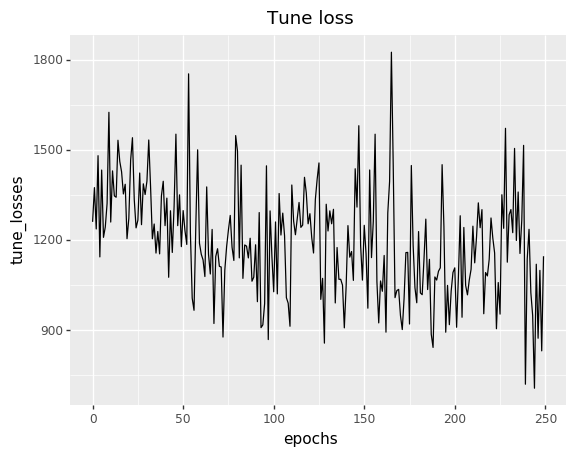

<ggplot: (8762393777037)>

In [4]:
metrics = {'epochs': list(range(epochs)), 'tune_losses': tune_losses, 'train_losses': train_losses,
          'tune_accuracies': tune_accuracies}

for key in metrics:
    print(len(metrics[key]))

metric_df = pd.DataFrame.from_dict(metrics)

ggplot(metric_df, aes(x = 'epochs', y = 'tune_losses')) + geom_line() + ggtitle('Tune loss')

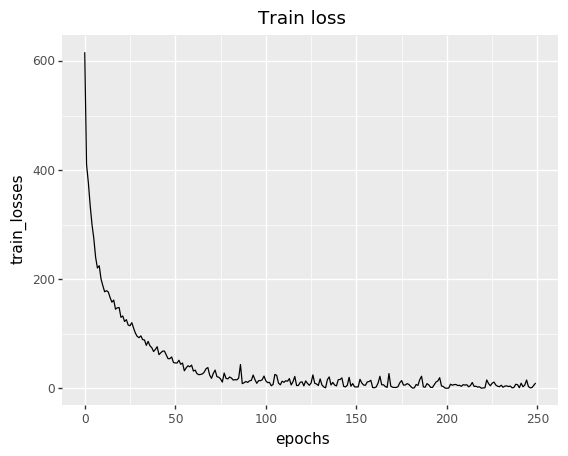

<ggplot: (8762392231657)>

In [5]:
ggplot(metric_df, aes(x = 'epochs', y = 'train_losses')) + geom_line() + ggtitle('Train loss')

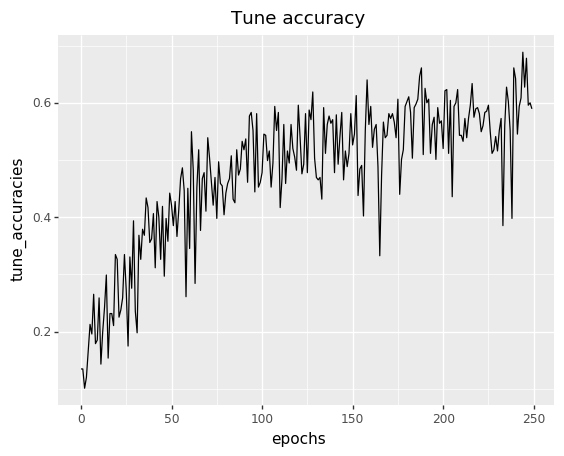

<ggplot: (8762392231513)>

In [6]:
ggplot(metric_df, aes(x = 'epochs', y = 'tune_accuracies')) + geom_line() + ggtitle('Tune accuracy')

Now, we provide code to evaluate BagNet-17.

In [1]:
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils import data
import torch
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from skimage.io import imread
from numpy.random import poisson, normal, beta, choice
import time
from copy import deepcopy, copy
from PIL import Image
import bagnets.pytorchnet

from dataset import patchnoiser, uniformnoiser, patchswap, tgenerator

In [2]:
seed = 42

np.random.seed(seed)                                                                       
torch.manual_seed(seed) 

img_transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])]
                                   )
dataset = ImageFolder(root='../data/train', transform=img_transform)

In [3]:
model_path = "../results/trained_bagnet.pkl"
bagnet = bagnets.pytorchnet.bagnet17(pretrained=False, num_classes = 12)
bagnet.load_state_dict(torch.load(model_path, map_location=device))
bagnet.eval() 

BagNet(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256,

In [4]:
index = list(range(794))
columns=['file','species']
df_ = pd.DataFrame(index = index, columns=columns)
df_ = df_.fillna(0)

In [5]:
test_data_dir = "../data/test"
testset = tgenerator(test_data_dir)
testset.viewmode()

Evaluate on clean test set.

Kaggle F1 Score: 0.72040

In [6]:
for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(bagnet(im),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_bagnet.csv", index = False)

0


/home/ben/anaconda3/envs/texture/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/ben/anaconda3/envs/texture/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


100
200
300
400
500
600
700


Evaluate on uniform noise perturbed test set.

Kaggle F1 Score: 0.11335

In [7]:
testset.setmode_uniformnoise(theta=0.6)

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(bagnet(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_unformnoise_bagnet.csv", index = False)

0
100
200
300
400
500
600
700


Evaluate on noisy patch perturbed test set.

Kaggle F1 Score: 0.20025

In [8]:
testset.setmode_noisypatch(theta=0.1,p=30,n=40)

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(bagnet(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_noisypatch_bagnet.csv", index = False)

0
100
200
300
400
500
600
700


Evaluate on patchswap perturbed test set.

Kaggle F1 Score: 0.52267

In [9]:
testset.setmode_patchswap(p=20, n=50)

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(bagnet(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_patchswap_bagnet.csv", index = False)

0
100
200
300
400
500
600
700


Evaluate on texturized test set.

Kaggle F1 Score: 0.19269

In [10]:
data_dir = "../data/texturized"
testset = tgenerator(data_dir)
testset.viewmode()

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(bagnet(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_texturized_bagnet.csv", index = False)

0
100
200
300
400
500
600
700
